In [6]:
# import required libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [7]:
#Loading the csv file from dataset into a DataFrame by Pandas
retail = pd.read_csv("C:/Users/Sai/Desktop/Data Engineering/K Means Clustering Project/OnlineRetail.csv",sep=",", encoding="ISO-8859-1", header=0)

In [8]:
#Getting more info about the DataSet
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
#Shape of our DataSet
retail.shape


(541909, 8)

<h1 style="font-size: 50px;">Data Cleaning</h1>



In [11]:
missing_data=100*(retail.isnull().sum()/len(retail))

In [12]:
missing_data
#Clearly only CustomerId is the column missing the majority of data

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [13]:
retail=retail.dropna()
#Dropping all the columns where the data was missing

In [14]:
retail.shape

(406829, 8)

In [15]:
#Changing the datatype of CustomerId from float to str
retail['CustomerID']=retail['CustomerID'].astype(str)

In [16]:
retail['CustomerID'].dtype

dtype('O')

In [17]:
retail['Amount']=retail['UnitPrice']*retail['Quantity']

In [18]:
#Adding new attribute:Monetary
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [19]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [21]:
rfm

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17
...,...,...,...
4367,18280.0,180.60,10
4368,18281.0,80.82,7
4369,18282.0,176.60,13
4370,18283.0,2094.88,756


In [22]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [23]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [24]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [25]:
# Compute recency of customer

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [26]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()


,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [27]:
#rmf=pd.merge(rmf,rfm_p2,on='CustomerID',how='inner')

In [28]:
# Merge the dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


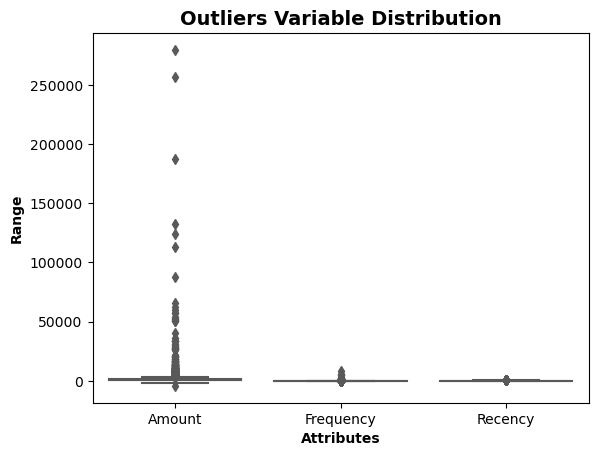

In [29]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2")
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [30]:
#Getting rid of all the outlier data points
#1.) Removing outliers in the case of Amount
Q1=rfm.Amount.quantile(0.05)
Q2=rfm.Amount.quantile(0.95)
IQR=Q2-Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q2 + 1.5*IQR)]

In [31]:
#2.) Removing outliers in the case of Frequency
Q1=rfm.Frequency.quantile(0.05)
Q2=rfm.Frequency.quantile(0.95)
IQR=Q2-Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q2 + 1.5*IQR)]

In [32]:
#3.) Removing outliers in the case of Recency
Q1=rfm.Recency.quantile(0.05)
Q2=rfm.Recency.quantile(0.95)
IQR=Q2-Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q2 + 1.5*IQR)]

<h1 style="font-size: 50px;">Scaling the features</h1>

In [33]:
rfm_df= rfm[['Frequency','Amount','Recency']]

In [55]:
#Using the StandardScalar
standard_scalar=StandardScaler()
rfm_df_scaled=standard_scalar.fit_transform(rfm_df)


In [65]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=['Frequency', 'Amount', 'Recency'])

<h1 style="font-size: 50px;">Model Building</h1>

In [74]:
#Using KMeans Clustering first
kmeans=KMeans(n_clusters=4,max_iter=50,n_init='auto')
kmeans.fit(rfm_df_scaled)



KMeans(max_iter=50, n_clusters=4, n_init='auto')

In [81]:
#Finding the best no of the clusters
ssd=[]
#Trying from 1 to 10 different types of clusters
for n in range(1,11):
    kmeans=KMeans(n_clusters=n,max_iter=50,n_init='auto')
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)

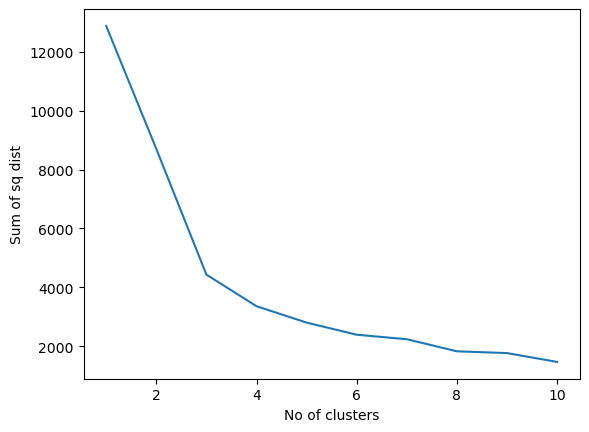

In [91]:
#Using Elbow curve to find the best n
plt.plot(range(1,11),ssd)
plt.xlabel('No of clusters')
plt.ylabel('Sum of sq dist');


In [96]:
#Analzing the decrease in ssd values
pd.Series(ssd).diff()


0            NaN
1   -4175.506304
2   -4269.906890
3   -1072.867703
4    -556.841691
5    -411.380923
6    -153.378247
7    -409.759986
8     -60.956868
9    -299.857177
dtype: float64

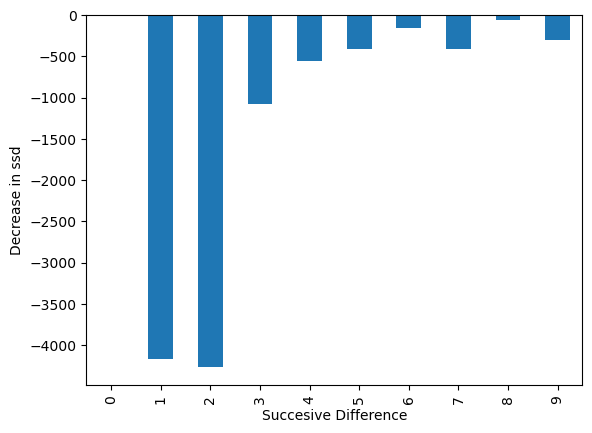

In [103]:
pd.Series(ssd).diff().plot(kind='bar')
plt.xlabel('Succesive Difference')
plt.ylabel('Decrease in ssd');

In [107]:
#Choosing n=3
kmeans=KMeans(n_clusters=3,n_init='auto')
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3, n_init='auto')

In [108]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [110]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


<h1 style="font-size: 50px;">Visualizing the clusters</h1>


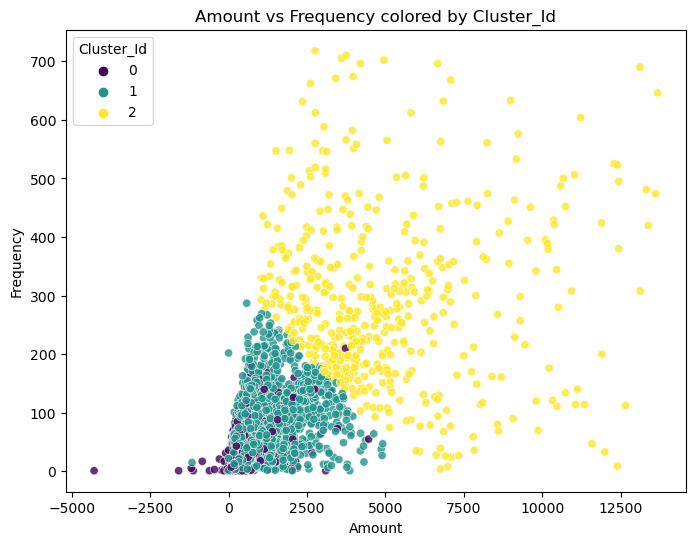

In [118]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Amount', y='Frequency', hue='Cluster_Id', palette='viridis', alpha=0.8)
plt.title('Amount vs Frequency colored by Cluster_Id')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(title='Cluster_Id')
plt.show()

<Figure size 800x600 with 0 Axes>

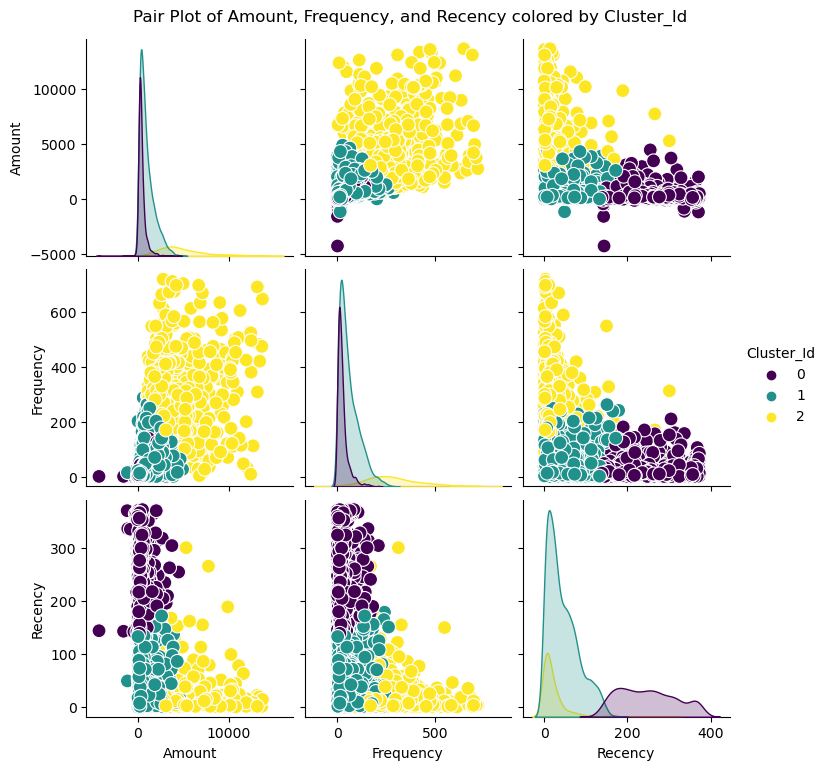

In [120]:
plt.figure(figsize=(8,6))
pair_plot = sns.pairplot(rfm, vars=['Amount', 'Frequency', 'Recency'], hue='Cluster_Id', palette='viridis', plot_kws={'s': 100})
pair_plot.fig.suptitle('Pair Plot of Amount, Frequency, and Recency colored by Cluster_Id', y=1.02)
plt.show();